In [13]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

In [14]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.tmp', cache_subdir='imdb')
shutil.rmtree('.tmp/imdb/aclImdb/train/unsup')

In [15]:
from tensorflow.keras.utils import text_dataset_from_directory

raw_train_dataset = text_dataset_from_directory('.tmp/imdb/aclImdb/train', validation_split=0.2, subset='training', seed=40)
raw_validation_dataset = text_dataset_from_directory('.tmp/imdb/aclImdb/train', validation_split=0.2, subset='validation', seed=40)
raw_test_dataset = text_dataset_from_directory('.tmp/imdb/aclImdb/test')

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [16]:
max_features = 10_000
sequence_length = 250

In [22]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

punctuation = f'[{re.escape(string.punctuation)}]'
def custom_standardization(input):
    input = tf.strings.lower(input)
    input = tf.strings.regex_replace(input, '<[^>]+>', ' ')
    return tf.strings.regex_replace(input, punctuation, '')

vectorize_layer = TextVectorization(
    standardize=custom_standardization, 
    max_tokens=max_features, 
    output_mode='int',
    output_sequence_length=sequence_length)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_text = raw_train_dataset.map(lambda x, _: x)
vectorize_layer.adapt(train_text)

train_dataset = raw_train_dataset.map(vectorize_text)
validation_dataset = raw_validation_dataset.map(vectorize_text)
test_dataset = raw_test_dataset.map(vectorize_text)

TextVectorization output_modes:
| output_mode=int | output_mode=binary | output_mode=count | output_mode=tf-idf |
| --------------- | --------------- | --------------- | --------------- |
| ![output_mode=int](./image/TextVectorization-output-mode-int.png) | ![output_mode=int](./image/TextVectorization-output-mode-binary.png) | ![output_mode=int](./image/TextVectorization-output-mode-count.png) | ![output_mode=int](./image/TextVectorization-output-mode-tfidf.png) |

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(AUTOTUNE)

In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dropout, GlobalAveragePooling1D, Dense

embedding_dim = 16

model = Sequential([
    Embedding(max_features + 1, embedding_dim),
    Dropout(0.2),
    GlobalAveragePooling1D(),
    Dropout(0.2),
    Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
________________________________________________

In [26]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

model.compile(
    optimizer='adam', 
    loss=BinaryCrossentropy(from_logits=True),
    metrics=[BinaryAccuracy(threshold=0.0)])

In [31]:
epochs = 10

history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 0.2175 - binary_accuracy: 0.9215 - val_loss: 0.2879 - val_binary_accuracy: 0.8862
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.2065 - binary_accuracy: 0.9256 - val_loss: 0.2864 - val_binary_accuracy: 0.8856
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1972 - binary_accuracy: 0.9300 - val_loss: 0.2858 - val_binary_accuracy: 0.8860
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1861 - binary_accuracy: 0.9345 - val_loss: 0.2865 - val_binary_accuracy: 0.8870
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1774 - binary_accuracy: 0.9379 - val_loss: 0.2878 - val_binary_accuracy: 0.8868
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1688 - binary_accuracy: 0.9421 - val_loss: 0.2898 - val_binary_accuracy: 0.8876
Epoch 7/10
625/625 [==============================] - 2s 3ms/ste

In [34]:
loss, accuracy = model.evaluate(test_dataset)
print(f'loss {loss}, accuracy {accuracy}')

782/782 [==============================] - 1s 889us/step - loss: 0.3364 - binary_accuracy: 0.8689
loss 0.3364090919494629, accuracy 0.8689200282096863


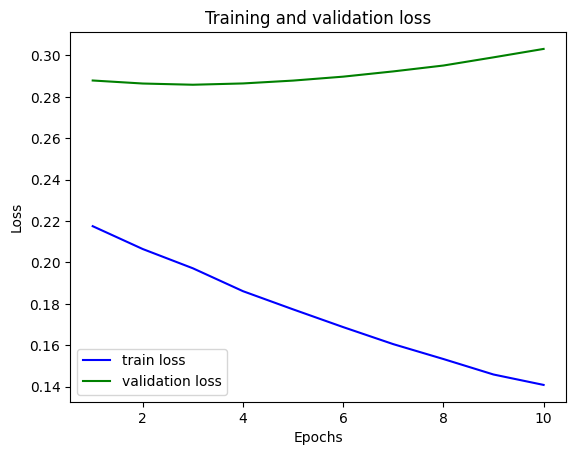

In [36]:
history_dict = history.history
accuracy = history_dict['binary_accuracy']
loss = history_dict['loss']
validation_accuracy = history_dict['val_binary_accuracy']
validation_loss = history_dict['val_loss']

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, loss, 'b', label='train loss')
plt.plot(epochs, validation_loss, 'g', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

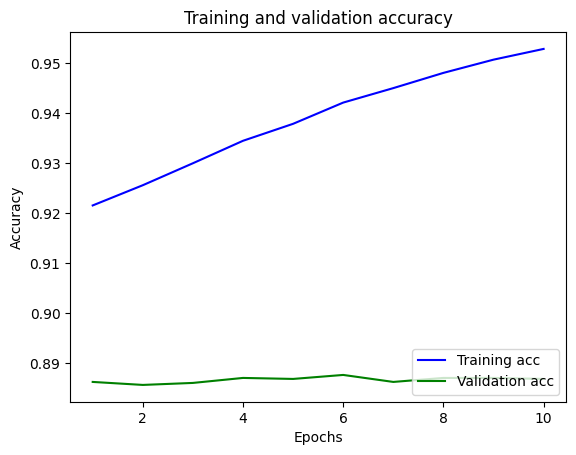

In [38]:
plt.plot(epochs, accuracy, 'b', label='Training acc')
plt.plot(epochs, validation_accuracy, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [40]:
from tensorflow.keras.layers import Activation

exported = Sequential([vectorize_layer, model, Activation('sigmoid')])
exported.compile(optimizer='adam', loss=BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

loss, accuracy = exported.evaluate(raw_test_dataset)

  1/782 [..............................] - ETA: 2:26 - loss: 0.1954 - accuracy: 0.8750

/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


782/782 [==============================] - 2s 2ms/step - loss: 0.3364 - accuracy: 0.8689


In [42]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

exported.predict(examples)

array([[0.6453657 ],
       [0.39131412],
       [0.27205157]], dtype=float32)